In [1]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, LayerNormalization, GlobalAveragePooling1D

nltk.download("stopwords")
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

# Modelling
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC

sns.set(font_scale=1.3)
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
from google.colab import files

# Mengunggah file konfigurasi Kaggle API
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
import shutil
import os

# Memindahkan file ke direktori Kaggle di Colab
if not os.path.exists('/root/.kaggle'):
    os.makedirs('/root/.kaggle')
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

'/root/.kaggle/kaggle.json'

In [4]:
!kaggle datasets download -d praveengovi/emotions-dataset-for-nlp

100% 721k/721k [00:00<00:00, 1.81MB/s]
100% 721k/721k [00:00<00:00, 1.81MB/s]


In [5]:
download_dir = '/content'

!unzip emotions-dataset-for-nlp.zip
!unzip glove-global-vectors-for-word-representation.zip

Archive:  emotions-dataset-for-nlp.zip
  inflating: test.txt                
  inflating: train.txt               
  inflating: val.txt                 
unzip:  cannot find or open glove-global-vectors-for-word-representation.zip, glove-global-vectors-for-word-representation.zip.zip or glove-global-vectors-for-word-representation.zip.ZIP.


In [6]:
df_train = pd.read_csv('/content/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/content/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/content/test.txt', names=['Text', 'Emotion'], sep=';')

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(16000, 2)
(2000, 2)
(2000, 2)


## Data Train

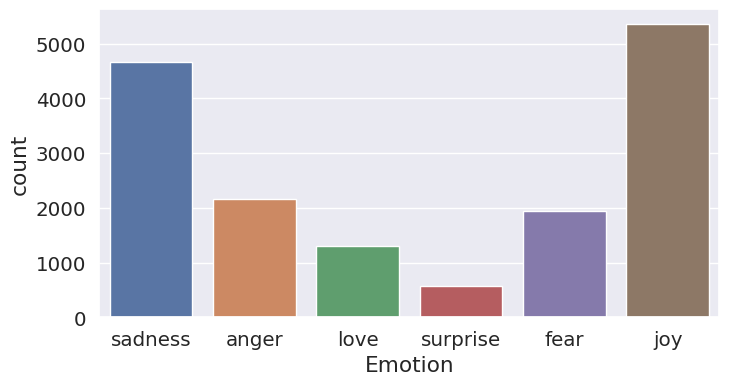

In [7]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_train);

In [8]:
print(df_train.shape)

df_train.groupby('Emotion').size()

(16000, 2)


Emotion
anger       2159
fear        1937
joy         5362
love        1304
sadness     4666
surprise     572
dtype: int64

In [9]:
#cek isnull and duplicated values
print(df_train.isnull().sum(),'\n')
print(df_train.duplicated().sum())

Text       0
Emotion    0
dtype: int64 

1


In [10]:
df_train[df_train['Text'].duplicated() == True].count()

Text       31
Emotion    31
dtype: int64

In [11]:
df_train[df_train.duplicated(keep=False)]

,Text,Emotion
4975,i feel more adventurous willing to take risks ...,joy
13846,i feel more adventurous willing to take risks ...,joy


In [12]:
#cek duplicated in the text but with different emotions
df_train[df_train['Text'].duplicated(keep=False)].groupby('Text')['Emotion'].agg(', '.join).reset_index()

,Text,Emotion
0,i am not amazing or great at photography but i...,"joy, love"
1,i began to feel accepted by gaia on her own terms,"love, joy"
2,i bet taylor swift basks in the knowledge that...,"fear, anger"
3,i cant escape the tears of sadness and just tr...,"love, joy"
4,i could feel myself hit this strange foggy wall,"fear, surprise"
5,i feel a remembrance of the strange by justin ...,"surprise, fear"
6,i feel im being generous with that statement,"love, joy"
7,i feel kind of strange,"fear, surprise"
8,i feel like a tortured artist when i talk to her,"fear, anger"
9,i feel like i am very passionate about youtube...,"joy, love"


In [13]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [14]:
#removing duplicated text
index = df_train[df_train['Text'].duplicated(keep=False) == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [15]:
print(df_train.shape)

df_train.groupby('Emotion').size()

(15939, 2)


Emotion
anger       2152
fear        1926
joy         5345
love        1289
sadness     4662
surprise     565
dtype: int64

## Test Dataset

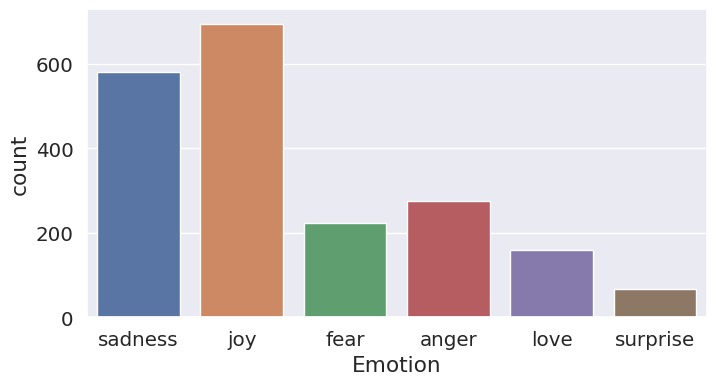

In [16]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_test);

In [17]:
#check if the data is balanced or not
#cek isnull and duplicated values
print(df_test.isnull().sum(),'\n')
print(df_test.duplicated().sum())

Text       0
Emotion    0
dtype: int64 

0


In [18]:
#print the rows which are duplicated
df_train[df_train['Text'].duplicated() == True].count()

Text       0
Emotion    0
dtype: int64

In [19]:
print(df_test.shape)

df_test.groupby('Emotion').size()

(2000, 2)


Emotion
anger       275
fear        224
joy         695
love        159
sadness     581
surprise     66
dtype: int64

## Validation dataset

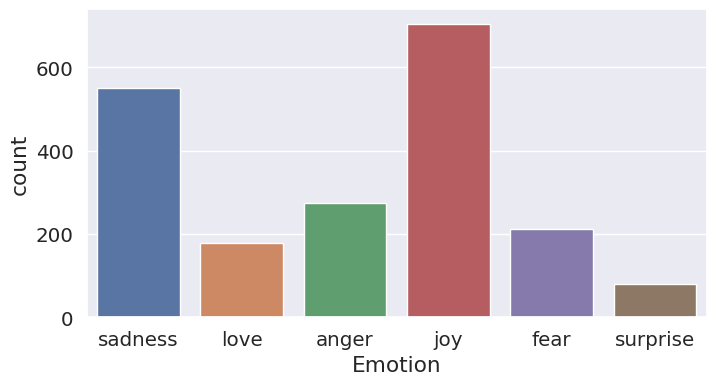

In [20]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_val);

In [21]:
#check if the data is balanced or not
df_val.Emotion.value_counts()

joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: Emotion, dtype: int64

In [22]:
#cek isnull and duplicated values
print(df_train.isnull().sum(),'\n')
print(df_train.duplicated().sum())

Text       0
Emotion    0
dtype: int64 

0


In [23]:
#print the rows which are duplicated
df_val[df_val['Text'].duplicated() == True].count()

Text       2
Emotion    2
dtype: int64

In [24]:
df_val[df_val['Text'].duplicated(keep=False)].groupby('Text')['Emotion'].agg(', '.join).reset_index()

,Text,Emotion
0,i feel so tortured by it,"fear, anger"
1,i have had several new members tell me how com...,"love, joy"


In [25]:
#removing duplicated text
index = df_val[df_val['Text'].duplicated(keep=False) == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

In [26]:
print(df_val.shape)

df_val.groupby('Emotion').size()

(1996, 2)


Emotion
anger       274
fear        211
joy         703
love        177
sadness     550
surprise     81
dtype: int64

## Compare rows of the datasets

In [27]:
#check that there is no data leakage

def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""

    # Combine the two DataFrames using a merge operation, with the
    # indicator parameter set to True. This adds a column called _merge
    # to the resulting DataFrame, which indicates the source of each row.
    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )

    # Filter the merged DataFrame based on the value of _merge. If which
    # is not specified, return all rows where _merge is not 'both'.
    # Otherwise, return all rows where _merge has the specified value
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]

    # Return the filtered DataFrame
    return diff_df

In [28]:
dataframe_difference(df_train, df_test, which='both')

,Text,Emotion,_merge


In [29]:
dataframe_difference(df_train, df_val, which='both')

,Text,Emotion,_merge


In [30]:
dataframe_difference(df_val, df_test, which='both')

,Text,Emotion,_merge


##Delete Class

In [31]:
# Salin DataFrame df_train, df_val, dan df_test ke df_train_new, df_val_new, dan df_test_new
df_train_new = df_train.copy()
df_val_new = df_val.copy()
df_test_new = df_test.copy()

# Hapus baris dengan label emosi 'love' dan 'surprise' dari df_train_new
df_train_new = df_train_new[(df_train_new['Emotion'] != 'love') & (df_train_new['Emotion'] != 'surprise')]

# Hapus baris dengan label emosi 'love' dan 'surprise' dari df_val_new
df_val_new = df_val_new[(df_val_new['Emotion'] != 'love') & (df_val_new['Emotion'] != 'surprise')]

# Hapus baris dengan label emosi 'love' dan 'surprise' dari df_test_new
df_test_new = df_test_new[(df_test_new['Emotion'] != 'love') & (df_test_new['Emotion'] != 'surprise')]


(14085, 2)


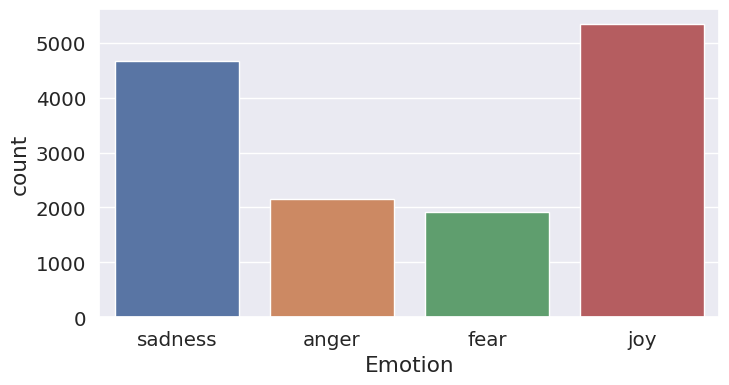

In [32]:
plt.figure(figsize=(8,4))
print(df_train_new.shape)
sns.countplot(x='Emotion', data=df_train_new);

(1775, 2)


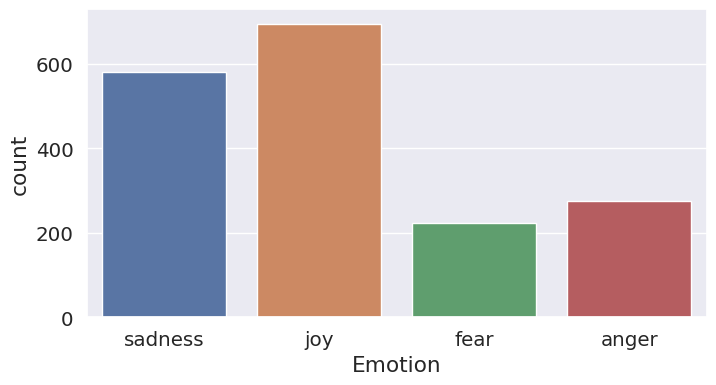

In [33]:
plt.figure(figsize=(8,4))
print(df_test_new.shape)
sns.countplot(x='Emotion', data=df_test_new);

(1738, 2)


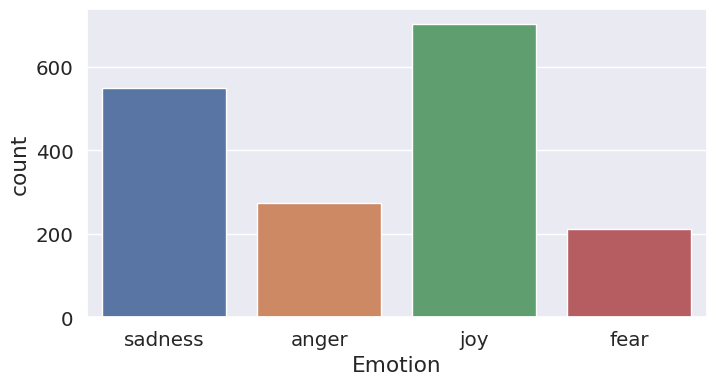

In [34]:
plt.figure(figsize=(8,4))
print(df_val_new.shape)
sns.countplot(x='Emotion', data=df_val_new);

| | Sadness | Joy | Fear | Anger |
| --- | --- | --- | --- | --- |
| **Train** | 4662 | 5345 | 1926 | 2152 |
| **Test** | 581 | 695 | 224 | 275 |
| **Validation** | 550 | 703 | 211 | 274 |

## Cleaning

In [35]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]

    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):

    text = text.split()

    text=[y.lower() for y in text]

    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )

    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stop_words(text))
    df.Text=df.Text.apply(lambda text : Removing_numbers(text))
    df.Text=df.Text.apply(lambda text : Removing_punctuations(text))
    df.Text=df.Text.apply(lambda text : Removing_urls(text))
    df.Text=df.Text.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

In [36]:
normalized_sentence("My Name is Mohamed. @Tweets,  plays 2022  Egypt_")

'name mohamed tweet play egypt'

In [37]:
df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)

In [38]:
df_train_new= normalize_text(df_train_new)
df_test_new= normalize_text(df_test_new)
df_val_new= normalize_text(df_val_new)

In [39]:
print(df_train.shape)
print(df_train_new.shape)

(15939, 2)
(14085, 2)


## Text Preprocessing

In [46]:
#Splitting the text from the labels
X_train_new = df_train_new['Text']
y_train_new = df_train_new['Emotion']

X_test_new = df_test_new['Text']
y_test_new = df_test_new['Emotion']

X_val_new = df_val_new['Text']
y_val_new = df_val_new['Emotion']

In [47]:
le = LabelEncoder()
y_train_new = le.fit_transform(y_train_new)
y_test_new = le.transform(y_test_new)
y_val_new = le.transform(y_val_new)

In [48]:
#print the labels after encoding
target_labels = []
for i, class_ in enumerate(le.classes_):
    target_labels.append(class_)
    print(f'{class_}: {i}')
print(target_labels)

anger: 0
fear: 1
joy: 2
sadness: 3
['anger', 'fear', 'joy', 'sadness']


In [49]:
#Convert the class vector (integers) to binary class matrix
y_train_new = to_categorical(y_train_new)
y_test_new = to_categorical(y_test_new)
y_val_new = to_categorical(y_val_new)
print(y_train_new)

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


## Tokenizing

In [50]:
# Tokenize words
import joblib
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(X_train_new)
joblib.dump(tokenizer, '/content/tokenizer_sentiment_new.joblib')

['/content/tokenizer_sentiment_new.joblib']

In [51]:
sequences_train_new = tokenizer.texts_to_sequences(X_train_new)
sequences_test_new = tokenizer.texts_to_sequences(X_test_new)
sequences_val_new = tokenizer.texts_to_sequences(X_val_new)

## Padding
The vectors we obtain are generally not of equal lengths

For that, we might need to pad the sequences to max len.

In [52]:
maxlen = max([len(t) for t in df_train_new['Text']])
maxlen

229

In [53]:
X_train_new = pad_sequences(sequences_train_new, maxlen=229, truncating='pre')
X_test_new = pad_sequences(sequences_test_new, maxlen=229, truncating='pre')
X_val_new = pad_sequences(sequences_val_new, maxlen=229, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 12467


## Modeling

In [54]:
print(X_val_new.shape)
print(y_val_new.shape)

(1738, 229)
(1738, 4)


In [55]:
# Build neural network architecture

adam = Adam(learning_rate=0.001)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train_new.shape[1]))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 229, 200)          2493400   
                                                                 
 bidirectional (Bidirection  (None, 229, 256)          336896    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 4)                 1028      
                                                                 
Total params: 3225564 (12.30 MB)
Trainable params: 3225564 (12.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Compile and Evaluate


In [56]:
def plot_history(history):

        fig, axs = plt.subplots(2)

        # create accuracy subplot
        axs[0].plot(history.history["accuracy"], label="train accuracy")
        axs[0].plot(history.history["val_accuracy"], label="test accuracy")
        axs[0].set_ylabel("Accuracy")
        axs[0].legend(loc="lower right")
        axs[0].set_title("Accuracy eval")

        # margin top
        fig.subplots_adjust(top=1.4, bottom=0.1, left=0.10, right=0.95)

        # create error subplot
        axs[1].plot(history.history["loss"], label="train error")
        axs[1].plot(history.history["val_loss"], label="test error")
        axs[1].set_ylabel("Error")
        axs[1].set_xlabel("Epoch")
        axs[1].legend(loc="upper right")
        axs[1].set_title("Error eval")

        plt.show()

In [57]:
# add callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='/content/model2.h5', save_best_only=True)

# train model
history = model.fit(X_train_new, y_train_new, validation_data=(X_val_new,y_val_new), batch_size=64, epochs=30, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
221/221 [==============================] - 42s 154ms/step - loss: 0.7196 - accuracy: 0.7081 - val_loss: 0.2569 - val_accuracy: 0.9235
Epoch 2/30
  1/221 [..............................] - ETA: 9s - loss: 0.0719 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


221/221 [==============================] - 14s 64ms/step - loss: 0.1132 - accuracy: 0.9620 - val_loss: 0.1573 - val_accuracy: 0.9419
Epoch 3/30
221/221 [==============================] - 14s 62ms/step - loss: 0.0362 - accuracy: 0.9884 - val_loss: 0.1657 - val_accuracy: 0.9407
Epoch 4/30
221/221 [==============================] - 15s 67ms/step - loss: 0.0264 - accuracy: 0.9916 - val_loss: 0.1806 - val_accuracy: 0.9499
Epoch 5/30
221/221 [==============================] - 12s 56ms/step - loss: 0.0212 - accuracy: 0.9931 - val_loss: 0.1867 - val_accuracy: 0.9436
Epoch 6/30
221/221 [==============================] - 13s 58ms/step - loss: 0.0138 - accuracy: 0.9958 - val_loss: 0.2329 - val_accuracy: 0.9436
Epoch 7/30
221/221 [==============================] - 12s 54ms/step - loss: 0.0133 - accuracy: 0.9961 - val_loss: 0.2111 - val_accuracy: 0.9494
Epoch 8/30
221/221 [==============================] - 12s 56ms/step - loss: 0.0105 - accuracy: 0.9962 - val_loss: 0.2300 - val_accuracy: 0.9419
Epo

56/56 [==============================] - 1s 23ms/step - loss: 0.1447 - accuracy: 0.9499
Train accuracy: 99.66%
Train loss:  1.03%
Validation accuracy: 95.34%
Validation loss: 20.54%
Test accuracy: 94.99%
Test loss: 14.47%


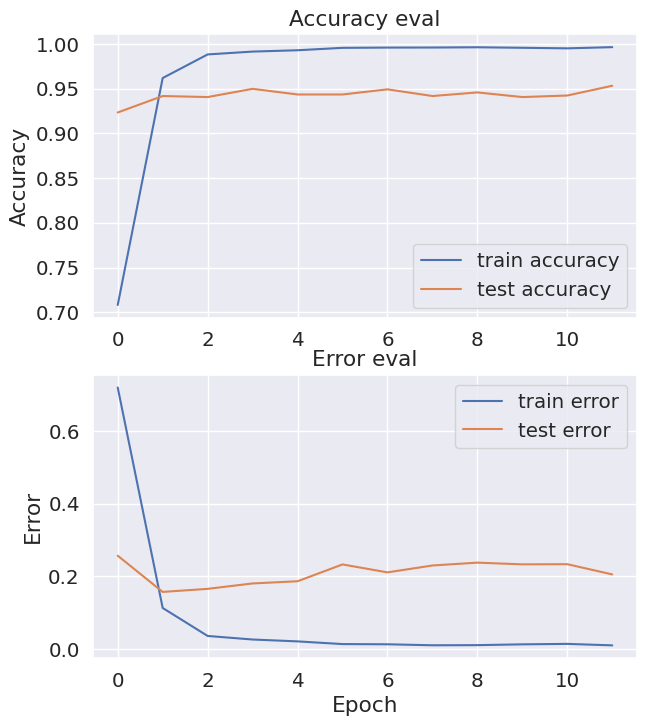

In [58]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test_new, y_test_new)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
print("Train accuracy: {:5.2f}%".format(100 * train_acc[-1]))
print("Train loss: {:5.2f}%".format(100 * train_loss[-1]))
print("Validation accuracy: {:5.2f}%".format(100 * val_acc[-1]))
print("Validation loss: {:5.2f}%".format(100 * val_loss[-1]))
print("Test accuracy: {:5.2f}%".format(100 * test_acc))
print("Test loss: {:5.2f}%".format(100 * test_loss))
plot_history(history)

### hidrrn

In [59]:
predicted = model.predict(X_test_new)
y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(df_test_new['Emotion']), y_pred, target_names=target_labels))

56/56 [==============================] - 2s 17ms/step
              precision    recall  f1-score   support

       anger       0.90      0.90      0.90       275
        fear       0.90      0.93      0.91       224
         joy       0.98      0.97      0.98       695
     sadness       0.96      0.95      0.96       581

    accuracy                           0.95      1775
   macro avg       0.93      0.94      0.94      1775
weighted avg       0.95      0.95      0.95      1775



<Axes: >

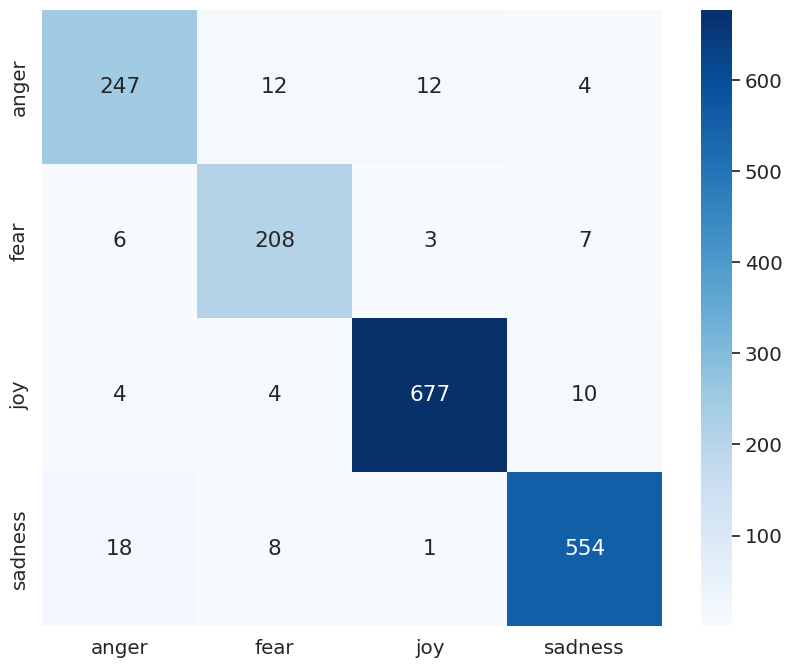

In [60]:
confusion = confusion_matrix(le.transform(df_test_new['Emotion']), y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g', xticklabels=target_labels, yticklabels=target_labels)